# A

In [1]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq', 'msdai']:
    os.chdir('/home/ms/github/fxpred')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot, ts_train_test_normalize
from transformer_architecture_elements import Time2Vector, SingleAttention, MultiAttention, TransformerEncoder

In [2]:
dtype = np.float32  # np.float64
df = get_fx_and_metric_data_wo_weekend(dtype=dtype)
target = 'EURUSD BGNE Curncy Bid Close'
target_column = list(df.columns).index(target)

df_close = get_fx_and_metric_data_wo_weekend(dtype=dtype, pct_change=False)
df = df.iloc[:, target_column : target_column + 1]

nn_type_classification = False
lag=128
h=1

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
def strategy(x):
    conditions = [
        (x <= -0.00000001),
        (x > -0.00000001) & (x <= 0.00000001),
        (x > 0.00000001)
    ]

    # create a list of the values we want to assign for each condition #!!! 
    values = ['sell', 'hold', 'buy']
    values = [0, 1, 2]

    # create a new column and use np.select to assign values to it using our lists as arguments #!!! 
    return np.select(conditions, values).astype(np.int32)
df['strategy'] = strategy(df[target])

df.head()

,EURUSD BGNE Curncy Bid Close,strategy
Dates,,
2020-11-01 19:10:00,0.000000,1
2020-11-01 19:20:00,0.000275,2
2020-11-01 19:30:00,-0.000069,0
2020-11-01 19:40:00,0.000034,2
2020-11-01 19:50:00,0.000026,2


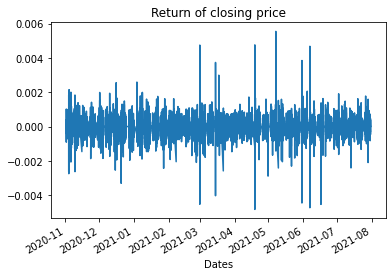

In [4]:
df[target].plot()
plt.title('Return of closing price')
plt.show()

In [5]:
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, 1)

In [6]:
X_train = sc.inverse_transform(X_train)
X_val = sc.inverse_transform(X_val)
X_test = sc.inverse_transform(X_test)
y_train = sc_target.inverse_transform(y_train)
y_val = sc_target.inverse_transform(y_val)
y_test = sc_target.inverse_transform(y_test)

In [7]:
def predictions(y):
    return y[:-1]

## Econmetric measures

Definition of cumulated returns

In [8]:
def cumulated_return(y_pred, ret, start_capital=1000, dtype=None):
    assert y_pred.flatten().shape == ret.flatten().shape
    balance = [start_capital]
    signal = 0
    for i, d in enumerate(y_pred[:-1]):
        signal = signal if d == 1 else d
        if signal == 0:
            balance.append(balance[-1])
        elif signal == 2:
            balance.append(balance[-1] * ret[i])
        else:
            raise ValueError()
    balance = np.array(balance, dtype=dtype)
    return balance

## read in data for econmic metric

In [9]:
def econ_metrics(y_pred, X_ret, risk_free=0):  # Risk free rate must be given
    x = cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype)
    print(f'Portfolio return: {x[-1] / x[0] - 1}')
    print(f'Std of returns: {np.std(x[1:] / x[:-1])}')
    print(f'Sharpe ratio: {((x[-1] / x[0]) - 1 - risk_free) / np.std(x[1:] / x[:-1])}')
    print()

    n = 6 * 24 * 250  # banking days per year
    mu_annum = ((x[-1]/x[0]) ** (1 / x.shape[0])) ** n - 1
    print(f'Return per annum: {mu_annum}')
    std_annum = np.std(x[1:] / x[:-1]) * (n)**0.5
    print(f'Std of returns per annum: {std_annum}')
    print(f'Sharpe ratio per annum: {(mu_annum - risk_free) / std_annum}')

(23079,)

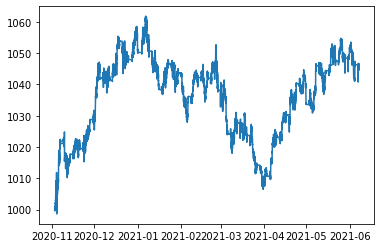

In [23]:
tmp_type='train'
# print(tmp_type)

y = eval(f"y_{tmp_type}")[1:]
y_pred = strategy(predictions(eval(f"y_{tmp_type}")))
# print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
# print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
# print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
# print(classification_report(y, y_pred))
# cm = confusion_matrix(y, y_pred)
# ConfusionMatrixDisplay(cm).plot()
# plt.show()

#     X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
X_ret = eval(f"X_{tmp_type}")[:, -1, 0] + 1
plt.plot(eval(f"index_{tmp_type}")[lag-1:-(h+1)][1:], cumulated_return(y_pred, X_ret[1:], dtype=dtype), label='predicted')

# p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
# x = np.concatenate(
#     [
#         cumulated_return(
#             np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
#             X_ret[1:],
#             dtype=dtype
#         )[:,np.newaxis] for i in range(50)
#     ], axis=-1
# )
# plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1), label='random', color='gray')
# plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
# plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
# plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
# plt.legend()
# plt.semilogy()
# plt.show()
# econ_metrics(y_pred, X_ret)

In [53]:
def result_output2(tmp_type):
    print(tmp_type)

    y = eval(f"y_{tmp_type}")[1:]
    y_pred = strategy(predictions(eval(f"y_{tmp_type}")))
    print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
    print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
    print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

#     X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
    X_ret = eval(f"X_{tmp_type}")[:, -1, 0] + 1
    plt.plot(eval(f"index_{tmp_type}")[lag-1:-(h+1)][1:], cumulated_return(y_pred, X_ret[1:], dtype=dtype), label='predicted')

    p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
    x = np.concatenate(
        [
            cumulated_return(
                np.random.choice([0, 1, 2], size=y_pred.shape, p=p),
                X_ret[1:],
                dtype=dtype
            )[:,np.newaxis] for i in range(50)
        ], axis=-1
    )
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1), label='random', color='gray')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][2:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[2:], dtype=dtype), label='buy&HODL')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][2:], cumulated_return(y[:-1], X_ret[2:], dtype=dtype), label='oracle')
    plt.legend()
    plt.semilogy()
    plt.show()
    econ_metrics(y_pred, X_ret[:-1])

train
Accuracy: 0.25528594851493835
Accuracy: 0.4709272086620331
KL_Divergence: -0.01751875877380371
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     10869
         1.0       0.02      0.25      0.04       926
         2.0       0.46      0.50      0.48     11285

    accuracy                           0.26     23080
   macro avg       0.16      0.25      0.17     23080
weighted avg       0.23      0.26      0.24     23080



/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


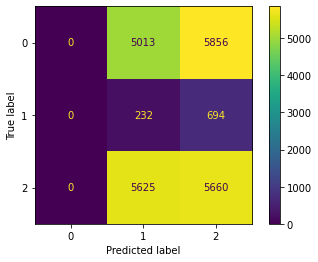

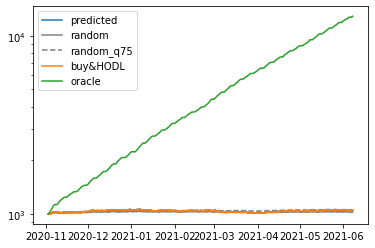

Portfolio return: 0.04612922668457031
Std of returns: 0.00033703859662637115
Sharpe ratio: 136.86630298816343

Return per annum: 0.07287808402819418
Std of returns per annum: 0.0639485774835645
Sharpe ratio per annum: 1.1396357338351217


In [54]:
result_output2('train')

val
Accuracy: 0.23637676239013672
Accuracy: 0.4940454661846161
KL_Divergence: -0.002206567209213972
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1369
         1.0       0.02      0.28      0.03        82
         2.0       0.45      0.48      0.46      1320

    accuracy                           0.24      2771
   macro avg       0.16      0.25      0.17      2771
weighted avg       0.22      0.24      0.22      2771



/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


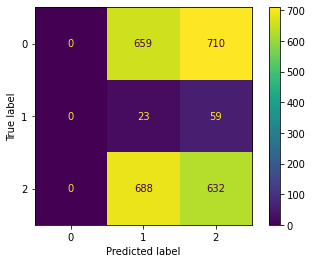

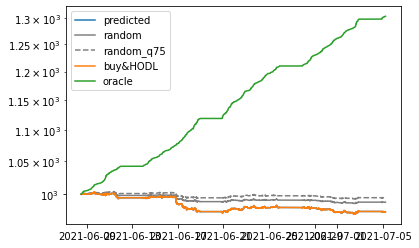

Portfolio return: -0.025885820388793945
Std of returns: 0.00030748150311410427
Sharpe ratio: -84.18659375158542

Return per annum: -0.2888366505168436
Std of returns per annum: 0.05834051329276355
Sharpe ratio per annum: -4.950876058758817


In [55]:
result_output2('val')

test
Accuracy: 0.264525443315506
Accuracy: 0.47347527742385864
KL_Divergence: -0.0021146940998733044
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1312
         1.0       0.02      0.36      0.04        75
         2.0       0.48      0.51      0.50      1384

    accuracy                           0.26      2771
   macro avg       0.17      0.29      0.18      2771
weighted avg       0.24      0.26      0.25      2771



/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


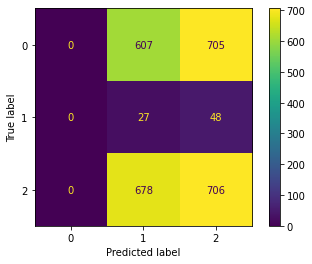

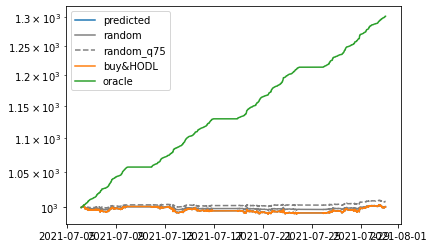

Portfolio return: 0.0006576776504516602
Std of returns: 0.00027933402452617884
Sharpe ratio: 2.3544487699529184

Return per annum: 0.00858123518333831
Std of returns per annum: 0.05299990472904369
Sharpe ratio per annum: 0.1619103888433187


In [56]:
result_output2('test')